# Example baseline model (threshold on silences)

In [18]:
import pandas as pd         # pandas==1.5.2
from sklearn import metrics # scikit-learn==1.1.3

In [21]:
table = "/home/yaron/Office/Home_Excercise/Tirza/data/SBC001_labels.csv"
df=pd.read_csv(table)
df.head()

,id,xmin,xmax,text,label
0,0,16.48,16.76,well,True
1,1,16.78,16.89,we're,True
2,2,16.89,17.06,gonna,False
3,3,17.06,17.32,have,False
4,4,17.32,17.40,to,False


In [20]:
baseline_pred = (df.xmin - df.xmax.shift().fillna(0) > 0.1) # example baseline model
metrics.cohen_kappa_score(df.label,baseline_pred) # requested metric

0.5163313636303637

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile

pearl_harbor = "/home/yaron/Office/Home_Excercise/Tirza/data/pearl_harbor_41-48.wav"
sbc_audio = "/home/yaron/Office/Home_Excercise/Tirza/data/mono_1.wav"
print(pearl_harbor)
print(sbc_audio)

/home/yaron/Office/Home_Excercise/Tirza/data/pearl_harbor_41-48.wav
/home/yaron/Office/Home_Excercise/Tirza/data/mono_1.wav


In [2]:
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset
import torch
import torchaudio

torch.random.manual_seed(0)

In [15]:
def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)
audio_signal, fs = torchaudio.load(sbc_audio)
print("fs = " + str(fs))
print(audio_signal.shape)
start_ind = int(15*fs)
end_ind = int(25*fs)

fs = 22050
torch.Size([1, 33427566])


2.0.1+cu117
2.0.2+cu117
torch.Size([1, 1025, 431])


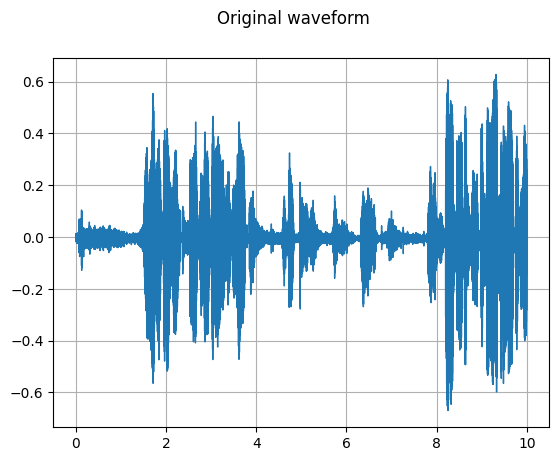

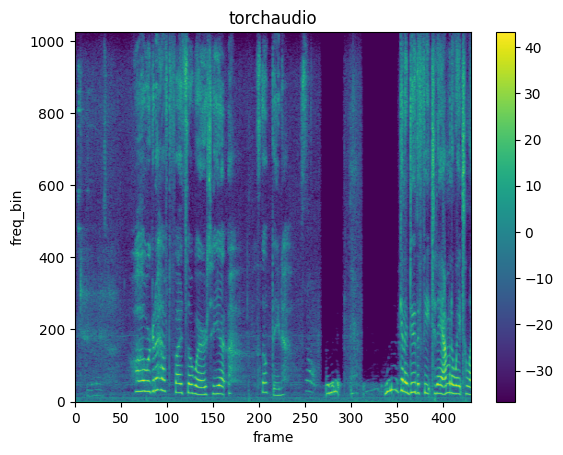

In [17]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)
n_fft = 2048
win_length = None
hop_length = 512

# Define transform
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)
#audio_signal, fs = torchaudio.load(pearl_harbor)
spec = spectrogram(torch.unsqueeze(audio_signal[0,start_ind:end_ind],0))
print(spec.shape)
plot_waveform(torch.unsqueeze(audio_signal[0,start_ind:end_ind], 0), fs, title="Original waveform")
plot_spectrogram(spec.squeeze(), title="torchaudio")
Audio(audio_signal[0,start_ind:end_ind].numpy(), rate=fs)

In [5]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)
print("Done")

Done


In [7]:
import time
start_time = time.time()
pitch = F.detect_pitch_frequency(audio_signal, fs)
run_time = time.time() - start_time
print("Done ({:.2f})".format(run_time))

Done (9.56)


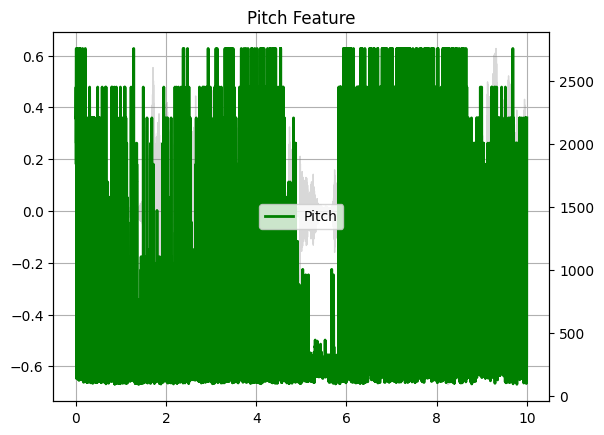

Done


In [8]:
def plot_pitch(waveform, sr, pitch):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sr
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    axis2.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")

    axis2.legend(loc=0)
    plt.show(block=False)


plot_pitch(torch.unsqueeze(audio_signal[0,start_ind:end_ind], 0), fs, pitch)
print("Done")

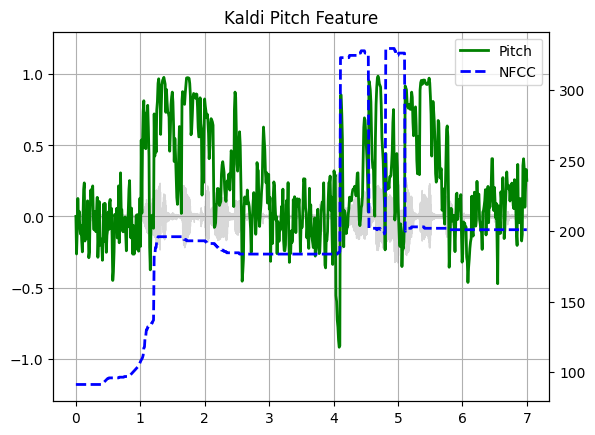

Done


In [49]:
def plot_kaldi_pitch(waveform, sr, pitch, nfcc):
    _, axis = plt.subplots(1, 1)
    axis.set_title("Kaldi Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sr
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    ln1 = axis.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")
    axis.set_ylim((-1.3, 1.3))

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, nfcc.shape[1])
    ln2 = axis2.plot(time_axis, nfcc[0], linewidth=2, label="NFCC", color="blue", linestyle="--")

    lns = ln1 + ln2
    labels = [l.get_label() for l in lns]
    axis.legend(lns, labels, loc=0)
    plt.show(block=False)


plot_kaldi_pitch(audio_signal, fs, pitch, nfcc)
print("Done")

In [48]:
start_time = time.time()
pitch_feature = F.compute_kaldi_pitch(audio_signal, fs)
pitch, nfcc = pitch_feature[..., 0], pitch_feature[..., 1]
run_time = time.time() - start_time
print("Done ({:.2f})".format(run_time))

Done (0.45)


fs = 48000
torch.Size([1, 267840])


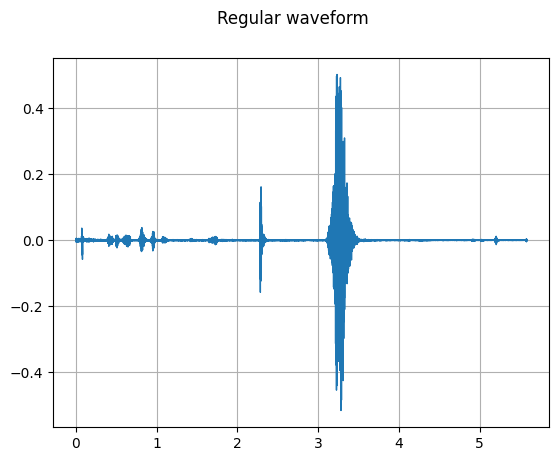

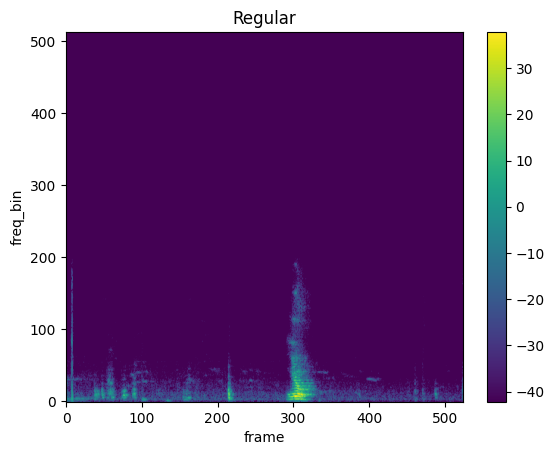

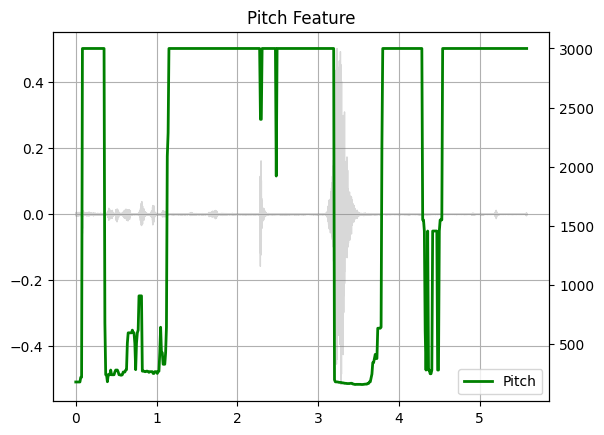

In [56]:
you_regular = "/home/yaron/Office/Home_Excercise/Tirza/data/you_regular.wav"
audio_signal, fs = torchaudio.load(you_regular)
print("fs = " + str(fs))
print(audio_signal.shape)
plot_waveform(audio_signal, fs, title="Regular waveform")
Audio(audio_signal.numpy(), rate=fs)
spec = spectrogram(audio_signal)
plot_spectrogram(spec[0], title="Regular")
pitch = F.detect_pitch_frequency(audio_signal, fs)
plot_pitch(audio_signal, fs, pitch)

fs = 48000
torch.Size([1, 138240])


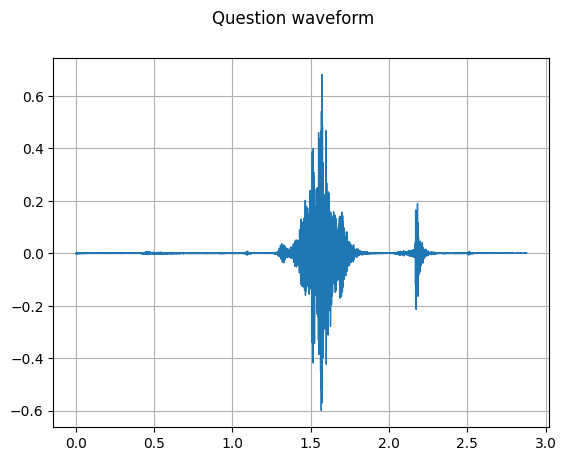

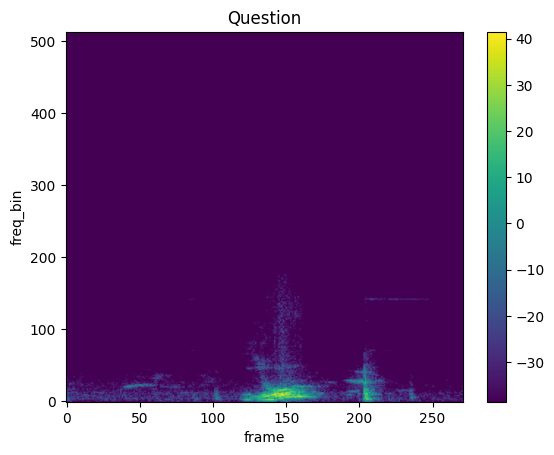

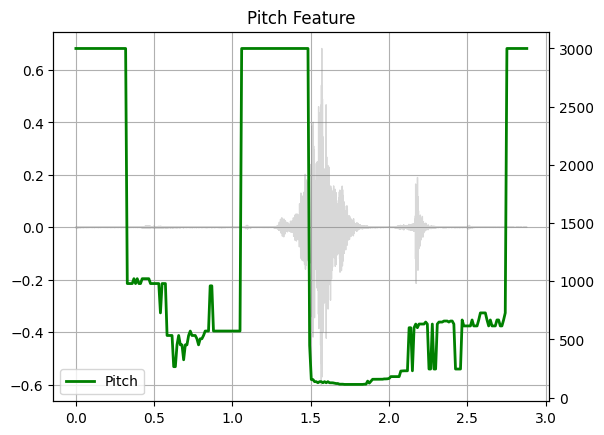

In [57]:
you_question = "/home/yaron/Office/Home_Excercise/Tirza/data/you_question.wav"
audio_signal, fs = torchaudio.load(you_question)
print("fs = " + str(fs))
print(audio_signal.shape)
plot_waveform(audio_signal, fs, title="Question waveform")
Audio(audio_signal.numpy(), rate=fs)
spec = spectrogram(audio_signal)
plot_spectrogram(spec[0], title="Question")
pitch = F.detect_pitch_frequency(audio_signal, fs)
plot_pitch(audio_signal, fs, pitch)

fs = 48000
torch.Size([1, 124800])


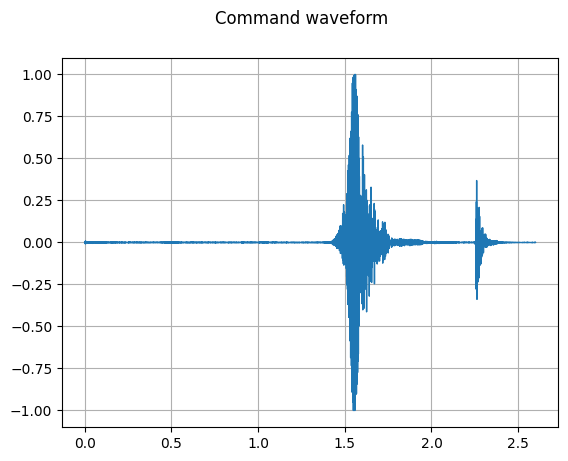

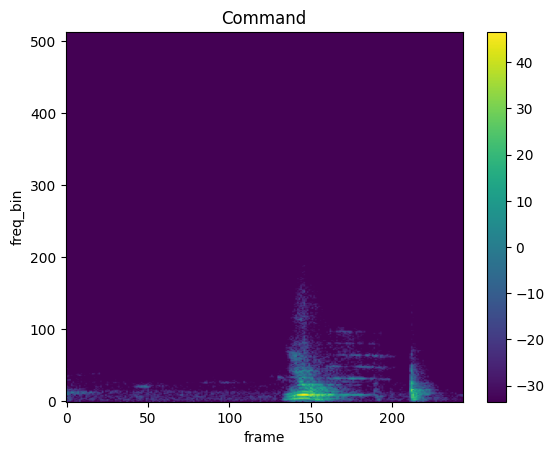

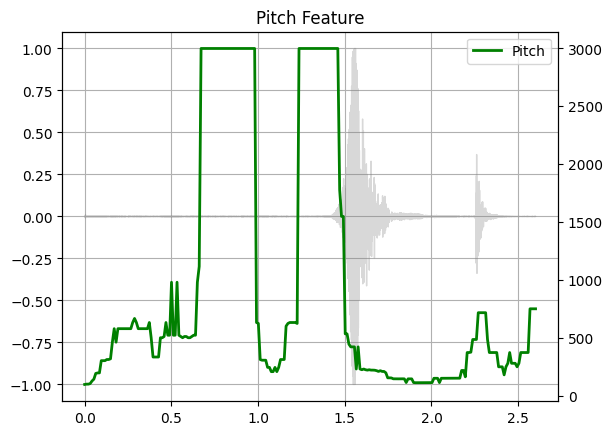

In [58]:
you_command = "/home/yaron/Office/Home_Excercise/Tirza/data/you_command.wav"
audio_signal, fs = torchaudio.load(you_command)
print("fs = " + str(fs))
print(audio_signal.shape)
plot_waveform(audio_signal, fs, title="Command waveform")
Audio(audio_signal.numpy(), rate=fs)
spec = spectrogram(audio_signal)
plot_spectrogram(spec[0], title="Command")
pitch = F.detect_pitch_frequency(audio_signal, fs)
plot_pitch(audio_signal, fs, pitch)